<a href="https://colab.research.google.com/github/tmnestor/Grad_Task/blob/main/Bert_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)

In [1]:
# #@title colab setup steps (takes about 12 minutes)
from google.colab import drive
drive.mount('/content/drive')
![[ -d "/content/drive/MyDrive/Colab Notebooks/Bert_Classification/" ]] && rm -rf "/content/drive/MyDrive/Colab Notebooks/Bert_Classification/"
%mkdir '/content/drive/MyDrive/Colab Notebooks/Bert_Classification/'
%cd '/content/drive/MyDrive/Colab Notebooks/Bert_Classification/'
!git clone https://github.com/tmnestor/Bert_Classification.git .
!pip3 install transformers


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Roberta_Classification
Cloning into '.'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 87 (delta 48), reused 57 (delta 22), pack-reused 0
Unpacking objects: 100% (87/87), 29.75 MiB | 4.86 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.7 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [3]:
# Setup device-agnostic code 

if torch.cuda.is_available():
    device = torch.device("cuda") # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps") # Apple GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
datapath = 'data/bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<AxesSubplot:xlabel='category'>

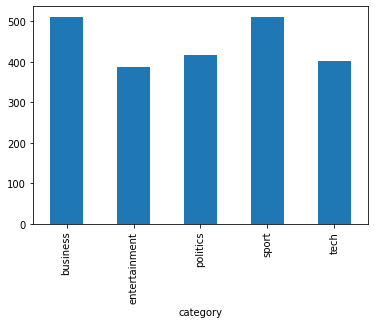

In [5]:
df.groupby(['category']).size().plot.bar()

In [6]:
MODEL = 'distilroberta-base'
# MODEL = 'distilbert-base-uncased'
# MODEL = 'roberta-base'
# MODEL = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
base = AutoModel.from_pretrained(MODEL)


# from transformers import BertTokenizer
# from transformers import DistilBertTokenizerFast
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# from transformers import RobertaTokenizer
# tokenizer = RobertaTokenizer.from_pretrained(MODEL)


labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [8]:

# from transformers import BertModel
# from transformers import DistilBertModel
# from transformers import RobertaModel
# base = RobertaModel.from_pretrained(MODEL)
# bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
# bert = BertModel.from_pretrained('bert-base-uncased')

# classifier = nn.Sequential(
#           nn.Dropout(0.2),
#           nn.Linear(768, 384),
#           nn.ReLU(),
#           nn.Dropout(0.2),
#           nn.Linear(384, 5),
#           nn.ReLU()
#         )

classifier = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(768, 5),
          nn.ReLU()
        )

class BertClassifier(nn.Module):

    def __init__(self, base, classifier):

        super(BertClassifier, self).__init__()
        self.base = base
        self.classifier = classifier

    def forward(self, input_id, mask):
        # _, cls_hs = self.base(input_ids= input_id, attention_mask=mask,return_dict=False)
        cls_hs = self.base(input_ids= input_id, attention_mask=mask,return_dict=False)[0][:, 0]
        x = self.classifier(cls_hs)
        return x
    
model = BertClassifier(base, classifier)

# freeze/unfreeze all the parameters in base model
for param in model.base.parameters():
    param.requires_grad = True
# freeze/unfreeze all the parameters in classifier head
for param in model.classifier.parameters():
    param.requires_grad = True


In [ ]:

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = DataLoader(val, batch_size=2)


    criterion = nn.CrossEntropyLoss()
    
    # optimizer = torch.optim.SGD(
    #     [{'params': filter(lambda p: p.requires_grad, model.bert.parameters()), 'lr':1e-4, },
    #     {'params': filter(lambda p: p.requires_grad, model.classifier.parameters())}], 
    #     lr=learning_rate, 
    #     momentum=0.95, 
    #     weight_decay=1e-5
    # )

    # optimizer = Adam(model.parameters(), lr= learning_rate['base_model'])
    optimizer = AdamW(
        [{'params': filter(lambda p: p.requires_grad, model.base.parameters()), 
        'lr':learning_rate['base'], },
        {'params': filter(lambda p: p.requires_grad, model.classifier.parameters())}], 
        lr= learning_rate['classifier'])


    model = model.to(device)
    criterion = criterion.to(device)

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {100*total_acc_train / len(train_data): .2f}% \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {100*total_acc_val / len(val_data): .2f}%')
                  
EPOCHS = 3

LR = {'base':1e-6, 'classifier':1e-5}
              
train(model, df_train, df_val, LR, EPOCHS)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/890 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/nlp_env/lib/python3.9/site-packages/transformers/models/roberta/modeling_roberta.py:1576: UserWarning: The operator 'aten::cumsum.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask
100%|██████████| 890/890 [03:33<00:00,  4.17it/s]


Epochs: 1 | Train Loss:  0.652                 | Train Accuracy:  44.38%                 | Val Loss:  0.162                 | Val Accuracy:  94.14%


100%|██████████| 890/890 [03:32<00:00,  4.19it/s]


Epochs: 2 | Train Loss:  0.088                 | Train Accuracy:  96.69%                 | Val Loss:  0.049                 | Val Accuracy:  97.30%


100%|██████████| 890/890 [03:32<00:00,  4.19it/s]


Epochs: 3 | Train Loss:  0.039                 | Train Accuracy:  98.76%                 | Val Loss:  0.028                 | Val Accuracy:  98.20%


100%|██████████| 890/890 [03:32<00:00,  4.19it/s]


Epochs: 4 | Train Loss:  0.027                 | Train Accuracy:  98.60%                 | Val Loss:  0.022                 | Val Accuracy:  99.10%


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = DataLoader(test, batch_size=2)

    model = model.to(device)

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {100*total_acc_test / len(test_data): .2f}%')
    
evaluate(model, df_test)

Test Accuracy:  98.21%


In [ ]:
# import torch, torchtext
# from torchtext.models import RobertaClassificationHead
# from torchtext.functional import to_tensor
# xlmr_large = torchtext.models.XLMR_LARGE_ENCODER
# classifier_head = torchtext.models.RobertaClassificationHead(num_classes=2, input_dim = 1024)
# model = xlmr_large.get_model(head=classifier_head)
# transform = xlmr_large.transform()
# input_batch = ["Hello world", "How are you!"]
# model_input = to_tensor(transform(input_batch), padding_value=1)
# output = model(model_input)
# output.shape

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class SquareDataset(Dataset):
     def __init__(self, a=0, b=1):
         super(Dataset, self).__init__()
         assert a <= b
         self.a = a
         self.b = b
        
     def __len__(self):
         return self.b - self.a + 1
        
     def __getitem__(self, index):
        assert self.a <= index <= self.b
        return index, index**2

data_train = SquareDataset(a=1,b=64)
data_train_loader = DataLoader(data_train, batch_size=1, shuffle=True)
print(len(data_train))

for idx, idx2 in data_train_loader:
    print(f"idx:{idx.item()}, idx2:{idx2.item()}")


64
idx:30, idx2:900
idx:21, idx2:441
idx:54, idx2:2916
idx:15, idx2:225
idx:40, idx2:1600
idx:38, idx2:1444
idx:60, idx2:3600
idx:63, idx2:3969
idx:11, idx2:121
idx:27, idx2:729
idx:20, idx2:400
idx:52, idx2:2704
idx:5, idx2:25
idx:61, idx2:3721
idx:51, idx2:2601
idx:39, idx2:1521
idx:32, idx2:1024
idx:35, idx2:1225
idx:14, idx2:196
idx:44, idx2:1936
idx:47, idx2:2209
idx:59, idx2:3481
idx:4, idx2:16


AssertionError: 